### Import Libraries

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

import string
import torch
import pickle5 as pickle
from heapq import nlargest
import sys
import spacy
# !pip install truecase
import truecase
from spacy import displacy
from collections import Counter
from nltk.tag import StanfordNERTagger
import en_core_web_sm
nlp = en_core_web_sm.load()
from pprint import pprint
# !pip install unidecode
from unidecode import unidecode
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel, euclidean_distances
import warnings
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.spatial import distance
import numpy as np
import re
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.cluster.util import cosine_distance
import tensorflow as tf
import transformers
from sent2vec.vectorizer import Vectorizer as S2vectorizer
tqdm_notebook.pandas()
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import networkx as nx

#import pipelines
from transformers import pipeline
nlp2 = pipeline("question-answering")

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 0)

c:\users\brgoh\anaconda33\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brgoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brgoh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brgoh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing

In [554]:
stop_words = stopwords.words("english")

def clean_normalcase_stop_lem(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    text = ' '.join([wordnet_lemmatizer.lemmatize(i) for i in text.split()])
    return text

def clean_normalcase_nostop_lem(text):
    text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    return text

def clean_lowercase_stop_lem(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    text = ' '.join([wordnet_lemmatizer.lemmatize(i) for i in text.split()])
    return text.lower()

def clean_lowercase_nostop_lem(text):
    text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
#     text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    return text.lower()

def clean_lowercase_nostop(text):
    text = ' '.join([word for word in text.split() if word not in stop_words])
#     text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    return text.lower()

## NER Generation

In [13]:
pprint([(X.text, X.label_) for X in nlp("America is a country").ents])

[('America', 'GPE')]


In [17]:
def generate_ners(text):
    result = set()
    for X in nlp(text).ents:
        result.add(unidecode(X.text.lower()))
    print(f"NERs: {result}")
    print('------------------')
    return result

In [365]:
df = pd.read_csv('../data/legal_squad_data.csv')

In [19]:
df = df.drop_duplicates(subset=['context'])
# df = df.dropna(subset=['doc'])
df['ners'] = df['context'].progress_apply(generate_ners)
# df['context'] = df['context'].apply(lambda x: str(x).lower())

NERs: {'the constitution of the united states', 'new york', 'george washington', 'the united states bill of rights', 'u.s.', 'the united states', 'first', '1790', 'philadelphia', 'the articles of confederation', 'united states congress', 'federal hall on wall street', 'the congress of the confederation', '1785', 'the supreme court of the united states', '1789'}
------------------
NERs: {'9/11', 'one', 'donald trump', 'trump', 'new york', 'weeks', 'the national review', 'america', 'republican', '2016', 'william f. buckley', '1955', "new york's", 'january 2016'}
------------------
NERs: {'over 35,000', 'the united states', 'the new york city police department', 'finest', "new york's"}
------------------
NERs: {'three', 'the city council', 'four-year', '51', 'the new york city rules', 'the city record', 'four years', 'the new york city administrative code'}
------------------
NERs: {'november 2008', 'new york city', 'democrats', 'calvin coolidge', 'democrat', 'the democratic party', '67%'

NERs: {'framers', 'chadha', '2/3', 'senate', 'the federal government', 'congress', '1983', 'the supreme court', 'houses', 'house', 'a house of representatives', 'two-thirds'}
------------------
NERs: {'senate', 'the united states', 'the supreme court', 'congress'}
------------------
NERs: {'murray', 'lessee', 'the united states', '1856', 'congress', 'the supreme court'}
------------------
NERs: {'senate', 'a two-thirds', 'two', 'congress'}
------------------
NERs: {'senate', 'the house of representatives'}
------------------
NERs: {'army', 'senate', 'the united states', 'the uniform code of military justice', 'congress', 'navy'}
------------------
NERs: {'the federalist papers', 'marbury', 'constitution', 'madison', 'the supreme court'}
------------------
NERs: {'a court of appeals', 'the supreme court', 'supreme court'}
------------------
NERs: {'the supreme court', 'congress'}
------------------
NERs: {'senate'}
------------------
NERs: {'51', 'james madison', 'constitution', 'republ

NERs: {'somali cabinet', 'the ministry of information', 'march 22, 2012', 'the national communications act', 'national communications'}
------------------
NERs: {'district', 'american', 'one', 'the "boston miracle', "the boston police department's", 'boston', 'the united states', '100,000', '5.26', 'the early 1990s', 'the 1990s', '1990', '26.5', '152', '1999'}
------------------
NERs: {"the thomas p. o'neill federal building", 'the united states district court', 'the federal reserve bank of boston', 'the john f. kennedy federal office building', 'the first circuit', 'the district of massachusetts', 'the united states court of appeals'}
------------------
NERs: {'democrat', 'senate', 'boston', 'elizabeth warren', 'the united states senate', 'republican', 'stephen lynch', 'kerry', 'over a century', '7th', '2013', 'democrats', 'the united states', 'mike capuano', 'ed markey', 'fourth', 'state', '1998', 'the 8th district', 'first', 'three-fourths', '2012', 'two', 'john kerry'}
------------

NERs: {'10:1', 'the united states', 'iran', 'congress'}
------------------
NERs: {'u.s.', 'congress', 'constitution', 'reid', 'the supreme court'}
------------------
NERs: {'3', 'parliament', 'india', 'parliament of india'}
------------------
NERs: {'european', 'ethiopia', 'qing dynasty china'}
------------------
NERs: {'native americans', '25', '1871', '120', 'u.s.c.', '563', 'the united states', 'march 3, 1871', '16', 'the indian appropriations act', 'indian', 'SS 71'}
------------------
NERs: {'nkvd', 'yugoslavia', '1935', 'stalin', 'walter"', 'the soviet communist party', 'the communist party', 'the soviet union', 'vienna', 'milan gorkic', '1936', 'moscow', 'boris kidric', 'the zagreb provincial committee', 'committee', 'the communist party of yugoslavia', 'soviet', 'aleksandar rankovic', 'balkans', 'tito', 'a year', '1934', 'edvard kardelj', 'milovan dilas', '1937', 'the dimitrov battalion', 'comintern', 'the spanish civil war', 'the central committee'}
------------------
NERs: {'

NERs: {'the chihuahuan state penitentiary', 'governor enrique c. creel', 'chihuahua city', 'miguel ahumada', 'the heroes theater', 'teatro de los heroes', '1908', '1901', 'first', 'the chuviscar river', 'from 1907 to 1911', 'creel', 'ciudad juarez', 'the civilian hospital of chihuahua', 'terrazas', 'september 16, 1897', 'august 18, 1904'}
------------------
NERs: {'95%', '5%', 'mexico', 'diaz', 'no re-election', 'porfiriato', '1876', '1910'}
------------------
NERs: {'porfirio diaz', 'durango', 'donato guerra', '1869', '1873', 'luis terrazas', 'benito juarez', '10 years', 'batopilas', 'general canto', 'august 1868', '1871', 'chihuahua', 'jose maria patoni', 'antonio ochoa', 'july 18, 1872', '1867', 'juarez', '1872'}
------------------
NERs: {'obregon', 'alvaro obregon', 'villa', 'teoloyucan', 'mexico city', 'carranza', 'august 20, 1914', 'zapata', 'august 15, 1914', 'huerta'}
------------------
NERs: {'j. a. pescador', 'simon ochoa', 'the middle of the following year', 'baca', 'decembe

NERs: {'the controlled substances act', 'dea', '1970', '1964', 'the united states civil rights act', 'the drug enforcement administration', 'rico) act', 'racketeer influenced and corrupt organizations', 'the united states department of justice', 'fbi'}
------------------
NERs: {'the u.s. department of homeland security', 'the september 11', 'u.s. customs and border protection', 'customs enforcement homeland security investigations', 'the u.s. coast guard', 'the joint terrorism task force', 'the national transportation safety board', 'ashcroft', 'fbi'}
------------------
NERs: {'1954', 'three', 'puerto rican', 'nationalist', 'abizu campos', 'the united states', 'us', 'u.s.', 'the freedom of information act', 'the us house of representatives', 'the 1980s', '1937', 'the 1930s', 'pedro albizu campos', 'luis gutierrez', '1950', 'fbi'}
------------------
NERs: {'the office of the director', 'fbi'}
------------------
NERs: {'96 million', 'j. edgar hoover building', 'yemen', 'iraq', 'virginia'

NERs: {'40 percent', 'nevada', '2 percent', 'cornell university', 'texas', '6 percent', 'california', '2.5 percent', 'only 1 percent', '2004', 'about four'}
------------------
NERs: {'1988', 'congress', 'the federal death penalty act', 'the supreme court', 'fifty', '1994', 'the drug kingpin act'}
------------------
NERs: {'amnesty international', 'the death penalty information center', 'davis', 'americans', 'the united states', 'america', 'richard dieter', 'troy davis', 'september 2011', 'brian evans'}
------------------
NERs: {'44', 'fifth', 'section 1983', '73', '4', 'the united states', '1973', '309', '2', '5', 'clemency', '1', '2014', '3', 'four'}
------------------
NERs: {'james liebman', '40 percent', '1991', 'ronald tabak', 'freedam', '1996', 'columbia law school', 'approximately 47 percent', '1978 to 1995'}
------------------
NERs: {'james french', 'between 1608', 'august 6, 1890', 'august 10, 1966', 'luis monge', 'first', 'oklahoma', 'kansas', 'james w. rodgers', 'george york'

NERs: {'$15.5m', 'shell', 'nigerian', 'the beginning of 1996', 'nigeria', '1995', 'royal dutch shell', 'brian anderson', 'ken saro-wiwa', 'ogoni', 'eight', '2009'}
------------------
NERs: {'shell', '2010', 'nigerian', 'nigeria', '2009'}
------------------
NERs: {'five', 'john clavering', 'two years', 'east india', 'richard barwell', 'parliament', 'council of four', 'act', 'bengal', 'british', '40,000', 'madras presidencies', 'three', 'crown', 'philip francis', 'calcutta', 'india', 'council', 'the court of directors', 'george monson', 'first', 'warren hastings', 'company', 'bombay', 'two'}
------------------
NERs: {'east india company', "pitt's act", 'edmund burke', 'regulating bill', '1783', 'british'}
------------------
NERs: {'d.f.', 'january 29, 2016', '32nd', 'recent years', 'the federal district', 'party of the democratic revolution', 'legislative assembly', 'distrito federal', 'spanish', 'the mexican constitution', 'years', '1997'}
------------------
NERs: {'the united mexican s

NERs: {'alex kozinski', 'atlantic', 'the eighteenth century', 'the united kingdom', 'english', 'constitution', 'the end of the 19th century', 'today'}
------------------
NERs: {'the founding fathers', 'the founding fathers of the united states', 'english', 'constitution', 'the supreme court', 'article three of the united states constitution'}
------------------
NERs: {'the nineteenth century', 'second', 'west publishing', 'u.s.', 'first', 'kozinski', 'today'}
------------------
NERs: {'tompkins', 'one', '1938', 'english', 'constitution', 'erie railroad co.'}
------------------
NERs: {'erie', 'one'}
------------------
NERs: {'american', 'one', 'the u.s. supreme court', 'the federal constitution', 'the centuries', 'senate', 'the united states', 'fifty', '50'}
------------------
NERs: {'103.5 million', '20.4 million', '272,795', '5.9 million', 'only about 282,000', '77,000', '1.5 million', '2012', '19.0 million', '56.3 million', '56,000', '1.9 million', "the national center for state cour

NERs: {'the french revolution', 'the whig party', 'whigs', '3 august 1791', 'fox', 'burke'}
------------------
NERs: {'1962', 'approximately one fifth', '1918-1919', 'the department of island territories', 'between 1919 and 1962', 'department', 'the league of nations', 'first', 'department of external affairs', 'the united nations', '1943', 'samoa', 'new zealand', 'two', 'the department of external affairs', "new zealand's", 'island territories', 'world war i'}
------------------
NERs: {"tupua tamasese mea'ole", 'malietoa tanumafili ii', 'five-year', 'one', '17 june 2007', 'first', 'july 2012', 'samoa', 'two', 'faumuina', '1963', '11 may 2007', 'four', 'state'}
------------------
NERs: {'samoans', 'more than 25,000', 'universal', 'fono', 'non-samoans', 'forty-seven', '1990', 'two', 'samoan', 'about 5%', '12', '49'}
------------------
NERs: {'vatican', 'pope paul', 'christians', '19 july 1968', 'the week of prayer for christian unity', 'the following three years', 'christian unity', 'sw

NERs: {'johnson', 'hobart taylor jr.', 'texas', 'first', 'nearly $7.5 billion', 'executive order 10925', 'a couple hundred', "john f. kennedy's"}
------------------
NERs: {'senate', 'gerald ford', 'yale', 'bill clinton', 'u.s.', 'george h. w. bush', '2008', 'clinton', 'john c. calhoun', 'dick cheney', 'hillary rodham clinton', 'new haven', 'george w. bush', 'yale law school', 'james hillhouse', 'state', '1801', '1968', 'william howard taft', 'two', 'john kerry', 'presidents bush'}
------------------
NERs: {'yale', 'the 1950s', "lyndon johnson's", '19th-century', 'great society', 'an american city', '1966', 'william f. buckley', "new haven's", 'american', 'the fifteenth ward', 'new haven', 'the great society', 'jr.', '1951', 'robert a. dahl', 'america', 'alexis de tocqueville', "william lee miller's"}
------------------
NERs: {'hispanic', '2003', 'ricci v. destefano', 'new haven', 'april 2009', 'the united states supreme court', '29 june 2009', 'yale law school', 'supreme court', '20', 

NERs: {'supreme court', 'england', '1998', 'the united kingdom', 'northern ireland', 'the judicial committee of the privy council', 'the high court of justiciary', '2005', 'the constitutional reform act', '1 october 2009', 'northern ireland act', 'the supreme court', 'the scotland act', 'wales', 'the house of lords', 'scotland'}
------------------
NERs: {'the court of appeals', 'one', 'maryland', 'new york', 'west virginia', 'the supreme court of appeals', 'massachusetts', 'the district of columbia', 'appellate division', 'the supreme court', 'the western hemisphere', 'maine', 'the "supreme judicial court'}
------------------
NERs: {'the administrative court (verwaltungsgerichtshof', 'gerichte', 'austria', 'the austrian constitution of 1920', 'oberste gerichtshof', 'hans kelsen', 'the constitutional court (verfassungsgerichtshof', 'the supreme court'}
------------------
NERs: {'the superior military tribunal (', 'the supreme federal tribunal (supremo tribunal federal', 'federal circuit

NERs: {'16th century', 'a. v. dicey', 'british', 'aristotle', 'the following century', 'scottish', 'samuel rutherford', 'the 19th century', 'law should govern', 'britain'}
------------------
NERs: set()
------------------
NERs: {'plato', 'west', 'aristotle'}
------------------
NERs: {'1607', 'deo', 'the case of prohibitions', 'quod rex', 'english', 'edward coke', 'bracton saith', 'majesty'}
------------------
NERs: {'english'}
------------------
NERs: {'greek', 'more than 200'}
------------------
NERs: {'the united states', 'first', 'congress', 'constitution', 'the supreme court'}
------------------
NERs: {'cicero', 'augustine', 'frederick mark gedicks', 'john harrison', 'thomas aquinas', 'constitution', 'the u.s. constitution'}
------------------
NERs: {'american', '1941', 'charles evans hughes', "a. v. dicey's", 'dicey', 'the united states', 'first'}
------------------
NERs: {'vietnam', 'china'}
------------------
NERs: {'three', '21st', '1932', 'thailand', 'november 2013'}
---------

NERs: {'the union of south africa', '1708', 'newfoundland', 'canada', 'the united kingdom', 'the united states declaration of independence', 'george iii', 'assent to laws', 'australia', 'new zealand', 'british'}
------------------
NERs: {'canada', 'commonwealth', 'uk', 'australia', 'the australian capital territory'}
------------------
NERs: {'the accurate news and information bill', 'three', 'commonwealth', 'the supreme court of canada', 'alberta', 'the balfour declaration of 1926', 'social credit', '1937', 'two', 'the statute of westminster 1931', 'third', 'john c. bowen', "william aberhart's", 'the judicial committee of the privy council'}
------------------
NERs: {'the united kingdom', 'parliament', 'the house of commons', '1911', '1949', 'lords commissioners', 'the house of lords'}
------------------
NERs: {'lords', 'state opening of parliament', 'the clerk of the parliaments', 'norman', 'the bar of the lords', 'the clerk of the crown', 'french', 'the imperial state crown', 'henry

NERs: {'only two', 'one', 'french', 'dutch', 'wallonia', 'brussels', 'belgian', 'third'}
------------------
NERs: {'one', 'senate', 'canadian', 'the german basic law', 'us', 'australia'}
------------------
NERs: {'spain', 'galicians', 'the basque country', 'catalans', 'galicia', 'catalonia', 'spanish', 'navarre', 'basques'}
------------------
NERs: {'australia', 'the united states', 'three-quarters', 'switzerland'}
------------------
NERs: {'australia', 'the united states', 'one'}
------------------
NERs: {'the us constitution', '39', 'states', 'the tenth amendment', 'james madison', 'the federal government', 'us', 'federalist paper', 'the united states constitution'}
------------------
NERs: {'states', 'brazil', 'mexico', 'second', 'the 1988 constitution', 'federal and state government', 'lei organica', 'two', 'third'}
------------------
NERs: {'chinese', 'centuries', 'china', "the people's republic of china"}
------------------
NERs: {'the autonomous region of muslim mindanao', 'one'

NERs: {'the alaska statehood committee', 'statehood', 'alaska', 'u.s.', 'first', 'congress', '1946', 'james wickersham', 'july 7, 1958', 'january 3, 1959'}
------------------
NERs: {'one', 'seven', 'alaska', 'department', 'five', 'the united states', 'the department of revenue tax division', 'two', 'annual'}
------------------
NERs: {'mccain', 'democrat', '1960', '59.49% to 37.83%', 'republican', 'john mccain', '1972', 'republicans', 'alaskan', '2008', '40%', 'one', 'sarah palin', 'lyndon b. johnson', 'alaska', '1964', '1968', 'first', 'democratic', '2012'}
------------------
NERs: {'council of paris', 'the 15th', '10', 'greens', 'socialists', '163', '91', 'the conseil de paris', 'communists', '2001-2014', '71', '1st through 9th', 'paris', 'bertrand delanoe', '36'}
------------------
NERs: {'the city of paris', 'metropole', 'the metropolitan council', '2020', 'nearly seven million', 'france', 'first', 'republican', 'january 22, 2016', 'rueil-malmaison', '210', 'metropolitan council', '

NERs: {'western australia', 'turnbull', 'malcolm turnbull', 'victoria', 'tony abbott', 'the september 2015 liberal', '18 september 2013', '2008', 'the abbott government', '2014', 'mike baird', '2013', 'will hodgman', 'three', 'south australia', 'bishop', 'julie bishop', 'adam giles', 'the liberal party', 'country liberal', 'the turnbull government', 'queensland', '2015', 'australia', 'the australian capital territory', 'colin barnett', 'new south wales', 'tasmania'}
------------------
NERs: {"holt's", 'harold holt', '1971', 'aboriginal land rights act', 'menzies', '1967', 'first', '1976', 'west australian', 'ken wyatt', 'indigenous australian', 'australia', 'neville bonner', 'the house of representatives', 'liberal governments', 'john gorton', '2010', "malcolm fraser's"}
------------------
NERs: {'six', 'the howard government', 'liberal party', '1983', "the liberal party's", 'liberal'}
------------------
NERs: {'arthur calwell', 'labor', 'john mcewen', 'senate', 'australian', 'dlp', 't

NERs: {'democrat', 'a week', 'republican', 'oval office', 'kerry', 'the sun', 'roger p. durkin', 'lowell', 'the merrimack river', 'lawrence', 'nixon', 'one', 'april', 'watergate', 'state', 'white house', 'independent', 'paul w. cronin', 'cronin'}
------------------
NERs: {'kerry 10', '53.45%', 'the week before', '92,847', '110,970', 'un-american', '13%', 'kerry', 'weeks', 'that year', 'congress', 'four days', 'new left', 'the final days', 'one', 'dukin', 'sun', 'durkin', '44.72%', 'two', 'cronin'}
------------------
NERs: {'kerry', "lou gehrig's", 'edward brooke', 'first', '1978', 'brooke', 'january 1977', 'droney'}
------------------
NERs: {'kerry', 'kennedy', '1979', 'da roanne sragow', 'wcvb-tv', 'k. dun gifford', '1978', 'kilvert & forbes ltd.', 'droney'}
------------------
NERs: {'1982', 'kerry', "tip o'neill", 'u.s.', 'paul tsongas', 'house', 'massachusetts', 'democratic', '1984', 'james shannon'}
------------------
NERs: {'aid package six weeks later', 'senate', 'tom harkin', '$

NERs: {'1960', 'greek', 'the house of representatives', 'turkish', 'the turkish cypriots', 'constitution', 'five-year'}
------------------
NERs: {'communist', 'democratic party', 'democratic rally', '59', 'maronite', 'latin', '2008', 'the house of representatives', 'dimitris christofias', 'nicos anastasiades', '28 february 2013', '2013', '56', 'edek', 'armenian', '24', '1964', 'first', 'turkish', 'democratic', '57.48%', 'rally', '3', 'christofias', 'five-year'}
------------------
NERs: {'american', 'canada', '1849', 'the united states', 'southwest', 'california', 'english', '1872', 'spanish', '46-39', 'eight', 'californio'}
------------------
NERs: {'confederates', 'charleston', 'king street', 'the red shirts', 'september 6', '1876', 'cainhoy', 'october 15', 'republican', 'democratic', '1872', 'the day', 'piedmont', 'wade hampton', 'republicans'}
------------------
NERs: {'democrat', 'more than six decades', 'the united states post office', 'about 1930', 'second', 'courthouse', 'the wi

NERs: {'four-year', '4', 'election day', 'november', 'that year', '2', '5', '3', 'another year', '1', 'september', '2011', 'the same year', '2013', '6'}
------------------
NERs: {'200', '33C/', 'new york city', '10', 'tucson', 'san francisco', '142,271', '2003', '2005', '300', '64C/', '1985', '79,222', '75%', '1:1'}
------------------
NERs: {'authoritarian', 'council of europe', 'kyrgyzstan', '5.21', 'us department of state', 'armenia 20th', '2008', 'the electoral commission', 'freedom house', '7', '29', '1995', 'democratic', 'russia', 'kosovo', 'armenia', 'moldova'}
------------------
NERs: {'peter leaver', 'sky', 'david chance', 'one', 'john quinton', 'the premier league', 'daily', 'the football association', 'fapl', 'november 1999', 'the football association premier league ltd', 'dave richards', 'march 1999', '20', 'sam chisholm', 'richard scudamore', 'april 1999'}
------------------
NERs: {'senate', 'roman', 'republic', 'the napoleonic code', 'plebeian', 'patricians', 'two', 'rome'

NERs: {'the falekaupule act', 'one', '1997'}
------------------
NERs: {'the falekaupule act', 'the council of elders', 'aganu'}
------------------
NERs: {'1915', 'fifth', 'ethiopia', 'south africa', 'liberia', 'un', 'the 1950s', 'a league of nations', 'german', "the herero chief's council", '1971', 'the swa legislative assembly', '1966', 'south african', 'swa', 'the 1960s', "south africa's", 'the international court of justice', 'european', '1946', '1919', 'the u.n. general assembly', 'namibia', 'world war i', 'africa', "south-west africa'", 'parliament of south africa', 'the united nations', 'united nations'}
------------------
NERs: {'the previous month', 'walvis bay', 'first', 'nelson mandela', 'south', '21 march 1990', 'february 1990', 'the national assembly', '147', '1994', '20', 'sam nujoma', 'namibia'}
------------------
NERs: {'2005', 'the swapo party', 'the national assembly', 'hifikepunye pohamba', 'sam nujoma', 'namibia', '15-year'}
------------------
NERs: {'continental', '

NERs: {'2006', 'republicans', 'second', '2003', 'dennis hastert', 'kevin mccarthy', 'eric cantor', 'tom delay', 'cantor', 'house', '2010', 'boehner'}
------------------
NERs: {'democrats', 'one', 'nancy pelosi', 'the 112th congress', 'house', '2010'}
------------------
NERs: {'the corrections calendar', 'rule xii', 'rule xv', 'house', 'rule ii', '6'}
------------------
NERs: {'the beginning days', 'james madison', 'capitol hill', 'virginia', 'first', 'congress', 'treasury', 'two', 'house', '20th-century', 'alexander hamilton'}
------------------
NERs: {'federalists', 'this early period', 'capitol hill', 'house', '1813', 'democratic', '36', '13', '1828'}
------------------
NERs: {'1839', 'from 1834 through 1859', 'seven', 'ninety-one', '1849', '1855', 'congresses', 'at least twenty', 'thirty-six', 'five', 'fourteen', 'democratic', '138', 'two', 'ninety-seven', '1859', '1861 to 1875', 'internal party'}
------------------
NERs: {'randall ripley', '1883', 'democrat', 'december 3, 1883', 'j

NERs: {'one', '1964', 'the board of estimate', 'the united states', '1898', 'brooklyn', 'the supreme court', "the fourteenth amendment's equal protection clause", '1989', 'the new york city board of estimate', 'the board than staten island'}
------------------
NERs: {'democrat', 'ruben diaz', '2005', 'republican', 'adolfo carrion jr.', 'bronx', 'may 1', 'democratic new york state assembly', '2001', '29,420', '86.3%', 'april 21, 2009', '4,646', 'the "bronx unity"', 'the white house office of urban affairs policy', 'anthony ribustello', 'borough', 'march 1, 2009', '13.3%'}
------------------
NERs: {'duncan hunter', 'republican', 'february 5, 2008', '37.8%', 'joe biden', 'john mccain', '8.2%', '20.8%', 'bronx', 'rudy giuliani', 'clinton', '54.4%', 'mitt romney', 'fred thompson', 'four', '7.4%', 'alan keyes', '1.0%', '148,636', 'dennis kucinich', 'john edwards', '5,643', 'bill richardson', 'the same day', 'mike huckabee', '5.6%', 'democratic', '3.6%', 'ron paul', '61.2%'}
-----------------

NERs: {'seven', 'territorial council', 'march 2012', 'com', 'the french parliament', 'first', 'st. barthelemy', 'nineteen', 'every five years', 'saint martin', '7 february 2007', '1 july 2007', 'five-year', '15 july 2007'}
------------------
NERs: {'the organization for security and cooperation in europe', 'tajik', 'united nations', 'rahmon', 'tajikistan', 'osce', 'the tajik government', 'november', 'abdumalik abdullajanov', '98%', 'around 1.2 million', 'more than 500,000', '100,000', 'the commonwealth of independent states', '30%', 'soviet', 'third', '1999', '79%', 'emomali rahmon', '2006', 'gerd d. merrem', '58%', 'west', '1992', 'october 2010', 'special representative', '1997'}
------------------
NERs: {'murodali', 'emomalii rahmon', "the people's democratic party", 'parliament', 'tajikistan', 'first', 'ruqiya qurbanova', 'november 1994', 'two', 'kokhir rasulzoda', 'matlubkhon davlatov'}
------------------
NERs: {'2010', 'tajik', 'pdpt', 'emomalii rahmon', 'parliament', 'february 20

## Extractive Summarisation

In [21]:
def extractive_summariser(text):

    length = 3

    # Remove punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    # Remove stopwords
    processed_text =[word for word in nopunc.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

    # Create a dictionary to store word frequency
    word_freq = {}
    # Enter each word and its number of occurrences
    for word in processed_text:
        if word not in word_freq:
              word_freq[word] = 1
        else:
              word_freq[word] = word_freq[word] + 1

    # Divide all frequencies by max frequency to give store of (0, 1]
    max_freq = max(word_freq.values())
    for word in word_freq.keys():
        word_freq[word] = (word_freq[word]/max_freq)

    # Create a list of the sentences in the text
    sent_list = nltk.sent_tokenize(text)
    # Create an empty dictionary to store sentence scores
    sent_score = {}
    for sent in sent_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_freq.keys():
                if sent not in sent_score.keys():
                    sent_score[sent] = word_freq[word]
                else:
                    sent_score[sent] = sent_score[sent] + word_freq[word]

    summary_sents = nlargest(length, sent_score, key = sent_score.get)
    summary = ' '.join(summary_sents)
    return summary

In [556]:
df['cleaned_lowercase_nostop'] = df['context'].progress_apply(clean_lowercase_nostop)
df['cleaned_normalcase_stop_lem'] = df['context'].progress_apply(clean_normalcase_stop_lem)
df['cleaned_normalcase_nostop_lem'] = df['context'].progress_apply(clean_normalcase_nostop_lem)
df['cleaned_lowercase_stop_lem'] = df['context'].progress_apply(clean_lowercase_stop_lem)
df['cleaned_lowercase_nostop_lem'] = df['context'].progress_apply(clean_lowercase_nostop_lem)
df['ner_combined'] = df['ners'].apply(lambda x: ' '.join(x).strip('[').strip(']').replace(',',''))

In [23]:
df['extractive_summarized_3_sent'] = df['context'].progress_apply(extractive_summariser)
df['extractive_summarized_3_sent'] = df['extractive_summarized_3_sent'].progress_apply(clean_lowercase_nostop_lem)

## Save Data

In [558]:
# df.to_csv('../data/legal_squad_doc_retrieval_cleaned_3_aprv2.csv')

## Load Data
Start from here

In [366]:
df = pd.read_csv('../data/legal_squad_doc_retrieval_cleaned_3_apr.csv')

In [367]:
df

,Unnamed: 0,Unnamed: 0.1,context_id,qna_id,context,question,answer_start,answer,ners,cleaned_normalcase_stop_lem,cleaned_normalcase_nostop_lem,cleaned_lowercase_stop_lem,cleaned_lowercase_nostop_lem,ner_combined,extractive_summarized_3_sent
0,0,0,3196,56cee398aab44d1400b88bfb,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",In what year did New York become the United States capital?,3,1785,"{'1785', 'new york', 'the united states bill of rights', 'george washington', 'u.s.', 'the united states', 'first', '1790', 'philadelphia', 'the articles of confederation', 'united states congress', 'federal hall on wall street', 'the congress of the confederation', 'the constitution of the united states', 'the supreme court of the united states', '1789'}",In 1785 the assembly of the Congress of the Confederation made New York the national capital shortly after the war New York wa the last capital of the U S under the Articles of Confederation and the first capital under the Constitution of the United States In 1789 the first President of the United States George Washington wa inaugurated the first United States Congress and the Supreme Court of the United States each assembled for the first time and the United States Bill of Rights wa drafted all at Federal Hall on Wall Street By 1790 New York had surpassed Philadelphia a the largest city in the United States,In 1785 assembly Congress Confederation made New York national capital shortly war New York last capital U S Articles Confederation first capital Constitution United States In 1789 first President United States George Washington inaugurated first United States Congress Supreme Court United States assembled first time United States Bill Rights drafted Federal Hall Wall Street By 1790 New York surpassed Philadelphia largest city United States,in 1785 the assembly of the congress of the confederation made new york the national capital shortly after the war new york wa the last capital of the u s under the articles of confederation and the first capital under the constitution of the united states in 1789 the first president of the united states george washington wa inaugurated the first united states congress and the supreme court of the united states each assembled for the first time and the united states bill of rights wa drafted all at federal hall on wall street by 1790 new york had surpassed philadelphia a the largest city in the united states,in 1785 assembly congress confederation made new york national capital shortly war new york last capital u s articles confederation first capital constitution united states in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street by 1790 new york surpassed philadelphia largest city united states,the constitution of the united states new york george washington the united states bill of rights u.s. the united states first 1790 philadelphia the articles of confederation united states congress federal hall on wall street the congress of the confederation 1785 the supreme court of the united states 1789,in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street new york last capital u s

In [368]:
context_docid_mapping = {}
for idx, rows in df.iterrows():
    context_docid_mapping[rows['context']] = idx
    
summarised_docid_mapping = {}
for idx, rows in df.iterrows():
    summarised_docid_mapping[rows['extractive_summarized_3_sent']] = idx

## Model 1: NER TF-IDF

In [369]:
ner_df = df[df['ner_combined'].isna() == False]

In [370]:
# TF-IDF Vectorizer for ner_combined column
ner_vectorizer = TfidfVectorizer(ngram_range=(1,2))
ner_tfidf_matrix = ner_vectorizer.fit_transform(ner_df['ner_combined'])

In [371]:
# Query preprocessing for NER document retrieval
def query_to_ner_str(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result)
    result = ' '.join([word for word in result.split() if word.lower() not in stop_words])
    result = ' '.join([X.text.lower() for X in nlp(truecase.get_true_case(result)).ents])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
query_to_ner_str('what is criminal law in united states?')

'united states'

In [582]:
def tfidf(df, vectorizer, tfidf_matrix, query, ner=False):
    if ner:
        query = query_to_ner_str(query)
    else:
        query = clean_query_lem(query)

    if query is None:
        return []
    
    doc_ids = get_similar_docs(df, vectorizer, tfidf_matrix, query)
    
    return doc_ids

In [583]:
def get_similar_docs(df, tfidfvectorizer, docs_tfidf_matrix, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query

    return: doc with highest tf-idf cosine similarity
    """
    query_tfidf = tfidfvectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf_matrix).flatten()
    max_sim = max(cosineSimilarities)
    
    if max_sim < 0.05: # not sure whether to set this threshold as some correct answers are like 0.1 similarity
#         print("No Matches")
        return []
    else:
        threshold = 0.6 * max_sim
    
    top_doc_ids = set()
    for idx, val in enumerate(cosineSimilarities):
        if val >= threshold:
            top_doc_ids.add((df.iloc[idx]['context_id'],val))
            
    top_doc_ids = sorted(top_doc_ids, key=lambda x: x[1], reverse=True)[:5]
            
#     print(f"Top Docs: {top_doc_ids}\n")
            
    return [i[0] for i in top_doc_ids]

In [572]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = tfidf(ner_df, ner_vectorizer, ner_tfidf_matrix, query, ner=True)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = ner_df[ner_df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43261, 43077, 16887, 8352, 82641]

1. Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties). Generally, crimes can result in incarceration, but torts (see below) cannot. The majority of the crimes committed in the United States are prosecuted and punished at the state level. Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud.


2. The law of the United States comprises many levels of codified and uncodified forms of law, of which the most important is the United States Constitution, the foundation of the federal government of the United States. The Constitution sets out the boundaries of federal law, which consists

## Model 2: Paragraph TF-IDF

In [405]:
# TF-IDF Vectorizer for cleaned_lowercase_nostop_lem column
para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
para_tfidf_matrix = para_vectorizer.fit_transform(df['cleaned_lowercase_nostop_lem'])

In [568]:
# Query preprocessing for paragraph document retrieval
def clean_query_lem(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result).lower()
    result = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in result.split() if word not in stop_words])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
query_normal_cleaning('what is criminal law in united states?')

'criminal law united state'

In [569]:
# Query preprocessing for paragraph document retrieval
def clean_query_nolem(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result).lower()
    result = ' '.join([word for word in result.split() if word not in stop_words])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
query_normal_cleaning_nolem('what is criminal law in united states?')

'criminal law united states'

In [411]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = tfidf(df, para_vectorizer, para_tfidf_matrix, query)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43077, 3196, 43261, 59316, 43233]

1. The law of the United States comprises many levels of codified and uncodified forms of law, of which the most important is the United States Constitution, the foundation of the federal government of the United States. The Constitution sets out the boundaries of federal law, which consists of acts of Congress, treaties ratified by the Senate, regulations promulgated by the executive branch, and case law originating from the federal judiciary. The United States Code is the official compilation and codification of general and permanent federal statutory law.


2. In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supr

## Model 3: Summary TF-IDF

In [455]:
# TF-IDF Vectorizer for cleaned_lowercase_nostop_lem column
summarised_vectorizer = TfidfVectorizer(ngram_range=(1,2))
summarised_tfidf_matrix = summarised_vectorizer.fit_transform(df['extractive_summarized_3_sent'])

In [456]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = tfidf(df, summarised_vectorizer, summarised_tfidf_matrix, query)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43077, 3196, 43261, 52701, 71584]

1. The law of the United States comprises many levels of codified and uncodified forms of law, of which the most important is the United States Constitution, the foundation of the federal government of the United States. The Constitution sets out the boundaries of federal law, which consists of acts of Congress, treaties ratified by the Senate, regulations promulgated by the executive branch, and case law originating from the federal judiciary. The United States Code is the official compilation and codification of general and permanent federal statutory law.


2. In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supr

## Model 4: NER + Paragraph TF-IDF

In [585]:
def two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, para_vectorizer, para_tfidf_matrix, query, col):
    if col == 'para':
        col = 'cleaned_lowercase_nostop_lem'
    elif col == 'summary':
        col = 'extractive_summarized_3_sent'
    else:
        print("Invalid col type. Specify 'para' or 'summary'.")
        return
    
    df = df.reset_index()
    ner_str = query_to_ner_str(query)
    ner_docs = []
    
    cleaned = query_normal_cleaning(query)

    if cleaned is None:
        return []

    if ner_str:    
#         print('========== EXECUTING NER TF-IDF ==========')
#         print(f"NER String: {ner_str}\n")

        ner_matching_ids = get_similar_docs(ner_df, ner_vectorizer, ner_tfidf_matrix, ner_str)

        if ner_matching_ids:
            narrowed_paras_df = ner_df[ner_df['context_id'].isin(i for i in ner_matching_ids)]
            para_index = narrowed_paras_df['context_id'].values
            
          # Re-run para_vectorizer and para_tfidf on narrowed down documents
            para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
            para_tfidf_matrix = para_vectorizer.fit_transform(narrowed_paras_df[col])
        else:
            para_index = df['context_id'].values
    else:
        para_index = df['context_id'].values
        
#     print('=== EXECUTING PARA TF-IDF ===')
#     print(f"Query String: {cleaned}\n")
    query_tfidf = para_vectorizer.transform([cleaned])
    cosineSimilarities = cosine_similarity(query_tfidf, para_tfidf_matrix).flatten()
    max_sim = max(cosineSimilarities)
    
    if max_sim < 0.05: # not sure whether to set this threshold as some correct answers are like 0.1 similarity
#         print("No Matches")
        return []
    else:
        threshold = 0.4 * max_sim

    top_doc_ids = set()
    for idx, val in enumerate(cosineSimilarities):
        if val >= threshold:
            top_doc_ids.add((para_index[idx],val))
            
    top_doc_ids = sorted(top_doc_ids, key=lambda x: x[1], reverse=True)[:5]
            
#     print(f"Top Docs: {top_doc_ids}\n")
            
    return [i[0] for i in top_doc_ids]

In [483]:
query = "what is criminal law in united states?"
retrieved_doc_ids = two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, para_vectorizer, para_tfidf_matrix, query, 'para')

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43261, 43077, 16887]

1. Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties). Generally, crimes can result in incarceration, but torts (see below) cannot. The majority of the crimes committed in the United States are prosecuted and punished at the state level. Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud.


2. The law of the United States comprises many levels of codified and uncodified forms of law, of which the most important is the United States Constitution, the foundation of the federal government of the United States. The Constitution sets out the boundaries of federal law, which consists of acts of C

## Model 5: NER + Summarised TFIDF

In [484]:
query = "what is criminal law in united states?"
retrieved_doc_ids = two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, summarised_vectorizer, summarised_tfidf_matrix, query, 'summary')

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43261, 43077]

1. Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties). Generally, crimes can result in incarceration, but torts (see below) cannot. The majority of the crimes committed in the United States are prosecuted and punished at the state level. Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud.


2. The law of the United States comprises many levels of codified and uncodified forms of law, of which the most important is the United States Constitution, the foundation of the federal government of the United States. The Constitution sets out the boundaries of federal law, which consists of acts of Congress

## Model 6: Latent Semantic Indexing (LSI) on Paragraph
https://github.com/arpytanshu/latent-semantic-indexing/blob/master/LSI.py

In [490]:
from numpy.linalg import svd, norm
from nltk.stem.snowball import EnglishStemmer
from collections import defaultdict, Counter

In [491]:
class LSI:
    def __repr__(self):
        return 'LSI( terms:{}, documents:{}, index_ready:{})'.format(self.index.__len__(),
                                                                     self.documents.__len__(),
                                                                     not(self.__update_index))
    
    def __init__(self, tokenizer=nltk.word_tokenize,
                 stemmer=EnglishStemmer,
                 stopwords=nltk.corpus.stopwords.words('english'),
                 variance=0.9):
        '''
        >>> queries cannot work unless __update_index is false.        
        '''
        self.stemmer = stemmer()
        self.tokenizer = tokenizer
        self.stopwords = stopwords
        
        self.documents = {}
        self.index = defaultdict(Counter)
        
        self.A = None # term document matrix
        self.U = None # output of svd
        self.S = None # output of svd
        self.V = None # output of svd
        
        self.term_rep = np.array(None) # reduced representation of terms after svd
        self.doc_rep = np.array(None)  # reduced representation of documents after svd
        
        self.__update_index = True
        self._term_index_in_A = {}
        self._document_index_in_A = {}
        
        self.k = None # reduced dimension after SVD
        self.variance = variance # variance to retain after SVD
            
        
    def add_doc(self, document, document_id):
        '''
        add terms into vocabulary.
        add document 
        '''
        if document_id in self.documents:
            print('document_id : {} already indexed.'.format(document_id))
            return False
        
        for token in [t.lower() for t in self.tokenizer(document) if t.isalpha()]:
            if token in self.stopwords:
                continue;
            if self.stemmer:
                token = self.stemmer.stem(token)
                
            # add this token to defaultdict(Counter)
            # this document's count is increased by 1 for this token's Counter
            self.index[token].update({document_id:1})
        
        self.__update_index = True # update flag to rebuild index
        self.documents[document_id] = document # add document to documents
        return True
    
    
    def _svd_A(self):
        '''
        Perform SVD on A and update the U,S,V matrices
        '''
        self.U, self.S, self.V = svd(self.A)
        
    
    def _get_k_for_svd(self):
        '''
        Finds the value for k after SVD such that specified variance is retained
        returns k : int
        '''
        if (self.S is not None):
            sum = 0
            k = 0
            while(sum < self.variance):
                k -=- 1
                sum = self.S[:k].sum() / self.S.sum()
            self.k = k
            return True
        else:
            print('S is not populated.')
            return False

    def rebuild_index(self):
        '''
        >>> set _update_index to false when index is built
        '''
        terms = list(self.index.keys())
        documents = list(self.documents.keys())
        self.A = np.zeros((terms.__len__(), documents.__len__()), dtype='int8')

        self._document_index_in_A = {doc:ix for ix,doc in enumerate(documents)}
        self._term_index_in_A = {term:ix for ix,term in enumerate(terms)}
        
        for term in terms:
            counter = self.index[term]
            term_ix = self._term_index_in_A[term]
            doc_ids = list(self.index[term].keys())
            doc_vals = [counter[x] for x in doc_ids]
            doc_ixs = [self._document_index_in_A[x] for x in doc_ids]
            for ix,doc_id in enumerate(doc_ixs):
                self.A[term_ix][doc_id] = doc_vals[ix]
        print('Term-Document frequency matrix is ready.')
        print('Proceeding to do SVD on the matrix.')
        
        self._svd_A()
        self._get_k_for_svd()
        
        self.doc_rep = self.V[:self.k,:]
        self.term_rep = self.U[:,:self.k]

        print('Index Rebuilt. Setting __update_index to False. Queries can now be performed.')
        self.__update_index = False
        
    def _calc_query_doc_affinity_score(self, query_vector):
        '''
        calculates the query - document affinity score
        '''
        try:
            one_by_query_vector_norm_ = (1/norm(query_vector))
        except ZeroDivisionError:
            one_by_query_vector_norm_ = (1/1e-4)
        affinity_scores = (np.dot(query_vector,self.doc_rep) / norm(self.doc_rep, axis=0)) * one_by_query_vector_norm_
        return affinity_scores
    
    def query(self, query_string, top=5):
        
        if(self.__update_index == True):
            print('Index is not updated. Use rebuild_index()')
            return False
        
        query_vector = []
        for token in [t.lower() for t in self.tokenizer(query_string) if t.isalpha()]:
            if token in self.stopwords:
                continue;
            if self.stemmer:
                token = self.stemmer.stem(token)
            try:
                query_vector.append(self.term_rep[self._term_index_in_A[token], :])
            except KeyError:
                query_vector.append(np.array([0.0] * self.k))
        
        query_vector_mean = np.array(query_vector).mean(axis=0)
        affinity_scores = self._calc_query_doc_affinity_score(query_vector_mean)
        
        res_doc_index = (-affinity_scores).argsort()[:top]
        results = []
        for index in res_doc_index:
            res_doc_id = list(self._document_index_in_A.keys())[index]
            results.append(res_doc_id)
            
        return results

In [495]:
def build_lsi(col):
    if col == 'para':
        col = 'cleaned_lowercase_nostop_lem'
    elif col == 'summary':
        col = 'extractive_summarized_3_sent'
    else:
        print("Invalid col type. Specify 'para' or 'summary'.")
        return
    
    lsi = LSI()

    for index, row in df.iterrows():
        lsi.add_doc(row[col], index)
        
    lsi.rebuild_index()
    
    return lsi
    
def lsi(query, lsi_model):
    doc_ids = lsi_model.query(query)
    result = []
    for i in doc_ids:
        result.append(df.iloc[i]['context_id'])
    return result

In [496]:
para_lsi_model = build_lsi('para')

Term-Document frequency matrix is ready.
Proceeding to do SVD on the matrix.
Index Rebuilt. Setting __update_index to False. Queries can now be performed.


In [497]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = lsi(query, para_lsi_model)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43077, 43233, 3196, 43243, 38264]

1. The law of the United States comprises many levels of codified and uncodified forms of law, of which the most important is the United States Constitution, the foundation of the federal government of the United States. The Constitution sets out the boundaries of federal law, which consists of acts of Congress, treaties ratified by the Senate, regulations promulgated by the executive branch, and case law originating from the federal judiciary. The United States Code is the official compilation and codification of general and permanent federal statutory law.


2. The fifty American states are separate sovereigns, with their own state constitutions, state governments, and state courts. All states have a legislative branch which enacts state statutes, an executive branch that promulgates state regulations pursuant to statutory authorization, and a judicial branch that applies, interprets, and occasionally overturns both state statutes and regulations, 

## Model 7: Latent Semantic Indexing (LSI) on Summary
https://github.com/arpytanshu/latent-semantic-indexing/blob/master/LSI.py

In [499]:
summary_lsi_model = build_lsi('summary')

Term-Document frequency matrix is ready.
Proceeding to do SVD on the matrix.
Index Rebuilt. Setting __update_index to False. Queries can now be performed.


In [500]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = lsi(query, summary_lsi_model)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43233, 43077, 13159, 3196, 43243]

1. The fifty American states are separate sovereigns, with their own state constitutions, state governments, and state courts. All states have a legislative branch which enacts state statutes, an executive branch that promulgates state regulations pursuant to statutory authorization, and a judicial branch that applies, interprets, and occasionally overturns both state statutes and regulations, as well as local ordinances. They retain plenary power to make laws covering anything not preempted by the federal Constitution, federal statutes, or international treaties ratified by the federal Senate. Normally, state supreme courts are the final interpreters of state constitutions and state law, unless their interpretation itself presents a federal issue, in which case a decision may be appealed to the U.S. Supreme Court by way of a petition for writ of certiorari. State laws have dramatically diverged in the centuries since independence, to the extent that

## Model 8: Sentence Embedding (Doc2Vec) on Paragraph

In [505]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def build_doc2vec(col):
    if col == 'para':
        col = 'cleaned_lowercase_nostop_lem'
    elif col == 'summary':
        col = 'extractive_summarized_3_sent'
    else:
        print("Invalid col type. Specify 'para' or 'summary'.")
        return
    doc2vec_df = df.reset_index()
    tagged_data = []
    for idx, d in doc2vec_df.iterrows():
        tagged_data.append(TaggedDocument(d[col].split(), [idx]))
    
    doc2vec_model = Doc2Vec(tagged_data, vector_size = 20, min_count = 2, epochs = 20)
    
    return doc2vec_model

def doc2vec(query, doc2vec_model):    
    test_query = word_tokenize(query.lower())
    test_query_vector = doc2vec_model.infer_vector(test_query)
    doc2vec_mostsimilar = doc2vec_model.docvecs.most_similar([test_query_vector])[:5]
    result = []
    for i in doc2vec_mostsimilar:
        result.append(df.iloc[i[0]]['context_id'])
    return result

In [506]:
para_doc2vec_model = build_doc2vec('para')

In [507]:
query = 'what is criminal law in america?'
retrieved_doc_ids = doc2vec(query, para_doc2vec_model)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[84635, 38264, 83019, 17015, 43091]

1. In the same judgement the ECHR reviewed the judgements of several international and municipal courts judgements. It noted that International Criminal Tribunal for the Former Yugoslavia and the International Court of Justice had agreed with the narrow interpretation, that biological-physical destruction was necessary for an act to qualify as genocide. The ECHR also noted that at the time of its judgement, apart from courts in Germany which had taken a broad view, that there had been few cases of genocide under other Convention States municipal laws and that "There are no reported cases in which the courts of these States have defined the type of group destruction the perpetrator must have intended in order to be found guilty of genocide".


2. United States v. LaMacchia 871 F.Supp. 535 (1994) was a case decided by the United States District Court for the District of Massachusetts which ruled that, under the copyright and cybercrime laws effective 

## Model 9: Sentence Embedding (Doc2Vec) on Summary

In [300]:
summary_doc2vec_model = build_doc2vec('summary')

In [513]:
query = 'what is criminal law in america?'
retrieved_doc_ids = doc2vec(query, summary_doc2vec_model)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43225, 84635, 32064, 52672, 76353]

1. Under the doctrine of Erie Railroad Co. v. Tompkins (1938), there is no general federal common law. Although federal courts can create federal common law in the form of case law, such law must be linked one way or another to the interpretation of a particular federal constitutional provision, statute, or regulation (which in turn was enacted as part of the Constitution or after). Federal courts lack the plenary power possessed by state courts to simply make up law, which the latter are able to do in the absence of constitutional or statutory provisions replacing the common law. Only in a few narrow limited areas, like maritime law, has the Constitution expressly authorized the continuation of English common law at the federal level (meaning that in those areas federal courts can continue to make law as they see fit, subject to the limitations of stare decisis).


2. In the same judgement the ECHR reviewed the judgements of several international a

## Model 10: Sentence Embedding (InferSent) on Paragraph

In [245]:
from models import InferSent
V = 2
MODEL_PATH = 'infersent/infersent2.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent_para = InferSent(params_model)
infersent_para.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'pretrained_embeddings/crawl-300d-2M.vec'
infersent_para.set_w2v_path(W2V_PATH)

In [246]:
sentences = list(df['cleaned_lowercase_nostop_lem'])
infersent_para.build_vocab(sentences, tokenize=True)

Found 10542(/11343) words with w2v vectors
Vocab size : 10542


In [247]:
infersent_para_embeddings = infersent_para.encode(sentences, tokenize=True)

In [79]:
# from numpy import asarray
# from numpy import save

# # save to npy file
# save('saved_models/legal_infersent_trained_embeddings_2_apr.npy', infersent_embeddings)

In [514]:
# from numpy import load

# # load array
# infersent_embeddings_loaded = load('saved_models/legal_infersent_trained_embeddings_2_apr.npy')

# print(infersent_embeddings_loaded)

In [533]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def infersent(query, model, embeddings):
    query_vec = model.encode([query])[0]
    similarity = []
    counter = 0
    for idx, row in df.iterrows():
        sim = cosine(query_vec, embeddings[counter])
        similarity.append((idx, sim))
        counter += 1

    doc_ids = [i[0] for i in sorted(similarity, key=lambda x: x[1], reverse=True)[:5]]
    result = []
    for i in doc_ids:
        result.append(df.iloc[i]['context_id'])
    return result

In [534]:
query = "Between 1973 and 2015, how amny prisoners were acquitted or received pardons or commutations of their death sentences due to possible innocence?"
retrieved_doc_ids = infersent(query, infersent_para, infersent_para_embeddings)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[32156, 32074, 32055, 66868, 32031]

1. In total, 156 prisoners have been either acquitted, or received pardons or commutations on the basis of possible innocence, between 1973 to 2015. Death penalty opponents often argue that this statistic shows how perilously close states have come to undertaking wrongful executions; proponents point out that the statistic refers only to those exonerated in law, and that the truly innocent may be a smaller number. Statistics likely understate the actual problem of wrongful convictions because once an execution has occurred there is often insufficient motivation and finance to keep a case open, and it becomes unlikely at that point that the miscarriage of justice will ever be exposed.


2. In 1976, contemporaneously with Woodson and Roberts, the Court decided Gregg v. Georgia and upheld a procedure in which the trial of capital crimes was bifurcated into guilt-innocence and sentencing phases. At the first proceeding, the jury decides the defendant's 

## Model 11: Sentence Embedding (InferSent) on Summary

In [250]:
V = 2
MODEL_PATH = 'infersent/infersent2.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent_summary = InferSent(params_model)
infersent_summary.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'pretrained_embeddings/crawl-300d-2M.vec'
infersent_summary.set_w2v_path(W2V_PATH)

In [251]:
sentences = list(df['extractive_summarized_3_sent'])
infersent_summary.build_vocab(sentences, tokenize=True)

Found 9061(/9647) words with w2v vectors
Vocab size : 9061


In [252]:
infersent_summary_embeddings = infersent_summary.encode(sentences, tokenize=True)

In [79]:
# from numpy import asarray
# from numpy import save

# # save to npy file
# save('saved_models/legal_infersent_trained_embeddings_2_apr.npy', infersent_embeddings)

In [253]:
# from numpy import load

# # load array
# infersent_embeddings_loaded = load('saved_models/legal_infersent_trained_embeddings_2_apr.npy')

# print(infersent_embeddings_loaded)

In [536]:
query = "Between 1973 and 2015, how amny prisoners were acquitted or received pardons or commutations of their death sentences due to possible innocence?"
retrieved_doc_ids = infersent(query, infersent_summary, infersent_summary_embeddings)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[32156, 32074, 32055, 66868, 84693]

1. In total, 156 prisoners have been either acquitted, or received pardons or commutations on the basis of possible innocence, between 1973 to 2015. Death penalty opponents often argue that this statistic shows how perilously close states have come to undertaking wrongful executions; proponents point out that the statistic refers only to those exonerated in law, and that the truly innocent may be a smaller number. Statistics likely understate the actual problem of wrongful convictions because once an execution has occurred there is often insufficient motivation and finance to keep a case open, and it becomes unlikely at that point that the miscarriage of justice will ever be exposed.


2. In 1976, contemporaneously with Woodson and Roberts, the Court decided Gregg v. Georgia and upheld a procedure in which the trial of capital crimes was bifurcated into guilt-innocence and sentencing phases. At the first proceeding, the jury decides the defendant's 

## Model 12: Para FAISS

In [562]:
para_question_pairs = df.loc[:, ['cleaned_lowercase_nostop', 'question']]
para_corpus = para_question_pairs['cleaned_lowercase_nostop'].tolist()
para_corpus = list(np.unique(para_corpus))

In [563]:
def most_similar(word, topn=5):
    word = nlp.vocab[str(word)]
    queries = [
      w for w in word.vocab 
      if w.is_lower == word.is_lower and w.prob >= -15 and np.count_nonzero(w.vector)
    ]

    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]

In [564]:
from sentence_transformers import SentenceTransformer
import scipy.spatial
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

In [565]:
%%time
para_faiss_embeddings = embedder.encode(para_corpus)

Wall time: 5min 20s


In [573]:
# Candidate Genration using Faiss vector similarity search library
import faiss
d = 768
index = faiss.IndexFlatL2(d)
print(index.is_trained)
index.add(np.stack(corpus_embeddings, axis=0))
print(index.is_trained)
print(index.ntotal)

ModuleNotFoundError: No module named 'faiss'

In [ ]:
# queries = ['What is the step by step guide to invest in share market in india?', 'How can Internet speed be increased by hacking through DNS?']
orig_query = "What is another name for the governing body of ministers?"
query = orig_query.lower()
query = clean_lowercase_nostop(query)
queries = [query]
query_embeddings = embedder.encode(queries)

In [ ]:
def faiss(query, embedder, faiss_index):
    query = clean_query_nolem(query)
    queries = [query]
    query_embeddings = embedder.encode(queries)
    k = 5
    for query, query_embedding in zip(queries, query_embeddings):
        distances, indices = index.search(np.asarray(query_embedding).reshape(1,768),k)
        print("\n======================\n")
        print("Query:", query)
        print("\nTop 5 most similar sentences in corpus:")
        for idx in range(0,5):
            print(corpus[indices[0,idx]], "(Distance: %.4f)" % distances[0,idx])
    result = []
    for idx in range(0,5):
        result.append(df.iloc[indices[0,idx]]['context_id'])
    
    return result

## Model 13: Summary FAISS

## Model Evaluation

In [588]:
question_docid_map = {}

all_qna = pd.read_csv('../data/legal_squad_data.csv')
for idx, row in all_qna.iterrows():
    qn, doc_id = row['question'], row['context_id']
    question_docid_map[qn] = doc_id

question_docid_map

{'In what year did New York become the United States capital?': 3196,
 "Who was the United States' first President?": 3196,
 'In what building did the Supreme Court of the United States first sit?': 3196,
 'On what street did the writing of the Bill of Rights occur?': 3196,
 'What was the second largest city in the United States in 1790?': 3196,
 'Which organization made New York the national capital in 1785?': 3196,
 'New York City became the first what under the new Constitution of the United States?': 3196,
 'The first president, George Washington, took office in what year?': 3196,
 'By which year, did New York City become the largest city in the United States?': 3196,
 'What individual established the National Review?': 3280,
 'In what year was the National Review founded?': 3280,
 'What public figure defended New York in January 2016?': 3280,
 'A presidential candidate from what party derided the city for its liberalism?': 3280,
 'The largest police presence in the US is NYPD with

In [592]:
model_names = ['NER TFIDF', 'Para TFIDF', 'Summary TFIDF', 'NER+Para TFIDF', 'NER+Summary TFIDF', 'Para LSI', 'Summary LSI', 'Para Doc2Vec', 'Summary Doc2Vec', 'Para InferSent', 'Summary InferSent', 'FAISS']
model_correct_retrievals = {}
for i in model_names:
    model_correct_retrievals[i] = 0

counter = 0
for query, doc_id in question_docid_map.items():
    counter += 1
    if counter < 1000:
        continue
    print(f"{doc_id}. {query}", end='\r')
    if doc_id in tfidf(ner_df, ner_vectorizer, ner_tfidf_matrix, query):
        model_correct_retrievals['NER TFIDF'] += 1
        
    if doc_id in tfidf(df, para_vectorizer, para_tfidf_matrix, query):
        model_correct_retrievals['Para TFIDF'] += 1
        
    if doc_id in tfidf(df, summarised_vectorizer, summarised_tfidf_matrix, query):
        model_correct_retrievals['Summary TFIDF'] += 1
        
    if doc_id in two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, para_vectorizer, para_tfidf_matrix, query, 'para'):
        model_correct_retrievals['NER+Para TFIDF'] += 1
        
    if doc_id in two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, summarised_vectorizer, summarised_tfidf_matrix, query, 'summary'):
        model_correct_retrievals['NER+Summary TFIDF'] += 1
        
    if doc_id in lsi(query, para_lsi_model):
        model_correct_retrievals['Para LSI'] += 1
        
    if doc_id in lsi(query, summary_lsi_model):
        model_correct_retrievals['Summary LSI'] += 1
        
    if doc_id in doc2vec(query, para_doc2vec_model):
        model_correct_retrievals['Para Doc2Vec'] += 1
        
    if doc_id in doc2vec(query, summary_doc2vec_model):
        model_correct_retrievals['Summary Doc2Vec'] += 1
        
    if doc_id in infersent(query, infersent_para, infersent_para_embeddings):
        model_correct_retrievals['Para InferSent'] += 1
        
    if doc_id in infersent(query, infersent_summary, infersent_summary_embeddings):
        model_correct_retrievals['Summary InferSent'] += 1
        
#     print(model_correct_retrievals, end='\r')

TypeError: only integer scalar arrays can be converted to a scalar index

In [310]:
query = "What's the only polytechnic school in New Zealand to be designated a university?"

In [311]:
two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, para_vectorizer, para_tfidf_matrix, query)

[464, 537, 862]

In [312]:
infersent(query, infersent_summary, infersent_summary_embeddings)

[49, 138, 135, 107, 231]

In [260]:
df.head(3)

,Unnamed: 0,Unnamed: 0.1,context_id,qna_id,context,question,answer_start,answer,ners,cleaned_normalcase_stop_lem,cleaned_normalcase_nostop_lem,cleaned_lowercase_stop_lem,cleaned_lowercase_nostop_lem,ner_combined,extractive_summarized_3_sent
0,0,0,3196,56cee398aab44d1400b88bfb,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",In what year did New York become the United States capital?,3,1785,"{'1785', 'new york', 'the united states bill of rights', 'george washington', 'u.s.', 'the united states', 'first', '1790', 'philadelphia', 'the articles of confederation', 'united states congress', 'federal hall on wall street', 'the congress of the confederation', 'the constitution of the united states', 'the supreme court of the united states', '1789'}",In 1785 the assembly of the Congress of the Confederation made New York the national capital shortly after the war New York wa the last capital of the U S under the Articles of Confederation and the first capital under the Constitution of the United States In 1789 the first President of the United States George Washington wa inaugurated the first United States Congress and the Supreme Court of the United States each assembled for the first time and the United States Bill of Rights wa drafted all at Federal Hall on Wall Street By 1790 New York had surpassed Philadelphia a the largest city in the United States,In 1785 assembly Congress Confederation made New York national capital shortly war New York last capital U S Articles Confederation first capital Constitution United States In 1789 first President United States George Washington inaugurated first United States Congress Supreme Court United States assembled first time United States Bill Rights drafted Federal Hall Wall Street By 1790 New York surpassed Philadelphia largest city United States,in 1785 the assembly of the congress of the confederation made new york the national capital shortly after the war new york wa the last capital of the u s under the articles of confederation and the first capital under the constitution of the united states in 1789 the first president of the united states george washington wa inaugurated the first united states congress and the supreme court of the united states each assembled for the first time and the united states bill of rights wa drafted all at federal hall on wall street by 1790 new york had surpassed philadelphia a the largest city in the united states,in 1785 assembly congress confederation made new york national capital shortly war new york last capital u s articles confederation first capital constitution united states in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street by 1790 new york surpassed philadelphia largest city united states,the constitution of the united states new york george washington the united states bill of rights u.s. the united states first 1790 philadelphia the articles of confederation united states congress federal hall on wall street the congress of the confederation 1785 the supreme court of the united states 1789,in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street new york last capital u s

## Method 7: InferSent + K-Means Clustering

In [95]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

In [96]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

In [98]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    print(f"Iteration: {k}")
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(infersent_embeddings_loaded)
    sse.append(kmeans.inertia_)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


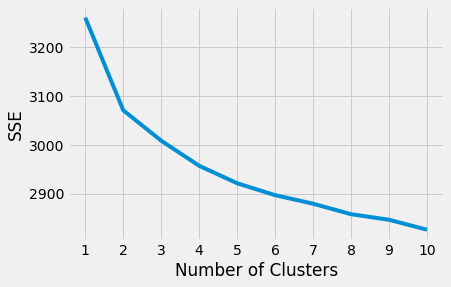

In [99]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [100]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [243]:
# To do: label docs to cluster, match new query to cluster and retrieve docs in that cluster

## ^ Not sure if this method makes sense? Like if we alr have the embeddings for each sentence, is there any benefit of clustering over direct cosine similarity?

## Method 8: Topic Modelling (LDA)
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [101]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [102]:
sentences = list(df['extractive_summarized_3_sent'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(sentences))

print(data_words[:1])

[['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new', 'york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new', 'york', 'national', 'capital', 'shortly', 'war']]


In [103]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new_york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new_york', 'national', 'capital', 'shortly', 'war']


In [104]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [105]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [106]:
print(data_words_bigrams[:1])

[['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new_york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new_york', 'national', 'capital', 'shortly', 'war']]


In [107]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 4), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 5), (23, 1), (24, 1), (25, 1), (26, 5), (27, 1), (28, 1), (29, 1)]]


### Building LDA Mallet Model

In [109]:
import os
os.environ.update({'MALLET_HOME':'C:/Users/User/Documents/GitHub/tmproj/document_retrieval/lda_mallet/mallet-2.0.8/'})

mallet_path = 'C:/Users/User/Documents/GitHub/tmproj/document_retrieval/lda_mallet/mallet-2.0.8/bin/mallet' # update this path

### Training LDA Mallet with Optimal Number of Topics

In [110]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [111]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

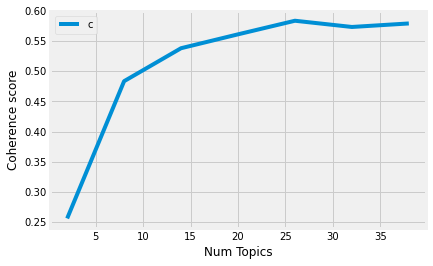

In [310]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [311]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2558
Num Topics = 8  has Coherence Value of 0.4835
Num Topics = 14  has Coherence Value of 0.5382
Num Topics = 20  has Coherence Value of 0.5612
Num Topics = 26  has Coherence Value of 0.5837
Num Topics = 32  has Coherence Value of 0.5734
Num Topics = 38  has Coherence Value of 0.5792


In [312]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(9,
  '0.023*"john" + 0.014*"woman" + 0.013*"death" + 0.013*"king" + '
  '0.013*"family" + 0.010*"royal" + 0.010*"men" + 0.008*"father" + 0.008*"son" '
  '+ 0.007*"william"'),
 (20,
  '0.047*"language" + 0.035*"term" + 0.027*"form" + 0.022*"english" + '
  '0.022*"word" + 0.019*"character" + 0.014*"common" + 0.012*"standard" + '
  '0.011*"meaning" + 0.011*"written"'),
 (10,
  '0.027*"company" + 0.025*"million" + 0.022*"world" + 0.020*"country" + '
  '0.019*"development" + 0.014*"economic" + 0.014*"industry" + 0.012*"market" '
  '+ 0.011*"billion" + 0.010*"economy"'),
 (16,
  '0.029*"th_century" + 0.024*"de" + 0.021*"early" + 0.020*"began" + '
  '0.019*"india" + 0.018*"european" + 0.017*"europe" + 0.016*"late" + '
  '0.015*"end" + 0.014*"established"'),
 (23,
  '0.047*"population" + 0.044*"people" + 0.024*"american" + 0.019*"group" + '
  '0.018*"community" + 0.018*"black" + 0.018*"number" + 0.016*"country" + '
  '0.015*"white" + 0.015*"child"'),
 (6,
  '0.055*"state" + 0.033*"law" + 0.0

In [331]:
## Save optimal LDA model as pkl file

# pickle.dump(optimal_model, open("lda_mallet/lda_optimal_model_2_apr.pkl", "wb"))

In [9]:
# Load optimal LDA model
optimal_lda_loaded = pickle.load(open("lda_mallet/lda_optimal_model_2_apr.pkl", "rb"))

### Finding the dominant topic in each sentence

In [19]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_lda_loaded, corpus=corpus, texts=data_words_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.3502,"music, record, work, house, number, song, popular, artist, single, album","[born, raised, houston, texas, performed, various, singing, dancing, competition, child, rose, fame, late, lead, singer, girl, group, destiny_child, hiatus, saw, release, beyonce, debut_album, dangerously, love, established, solo_artist, worldwide, earned, five, grammy_award, featured, billboard_hot, number, one, single, crazy, love, baby, boy, beyonce, giselle, knowles, carter, bi, jansei, bee, yon, say, born, september, american, singer_songwriter, record, producer, actress]"
1,1,17.0,0.3887,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, took, hiatus, music, took, management, career, fourth, album, subsequently, mellower, tone, exploring, funk, pop, soul, marriage, rapper, jay, portrayal, etta, james, cadillac, record, influenced, third, album, sasha_fierce, saw, birth, alter, ego, sasha_fierce, earned, record, setting, six, grammy_award, including, song, year, single, lady_put, ring, critically, acclaimed, fifth, studio_album, beyonce, distinguished, previous, release, experimental, production, exploration, darker, theme]"
2,2,17.0,0.2720,"music, record, work, house, number, song, popular, artist, single, album","[throughout, career, spanning, year, sold, million, record, solo_artist, million, destiny_child, making, one, best_selling, music, artist, time, stage, dynamic, highly, choreographed, performance, led, critic, hailing, one, best, entertainer, contemporary, popular, music, self, described, modern, day, feminist, beyonce, creates, song, often, characterized, theme, love, relationship, monogamy, well, female, sexuality, empowerment]"


In [20]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,17.0,0.3502,"music, record, work, house, number, song, popular, artist, single, album","[born, raised, houston, texas, performed, various, singing, dancing, competition, child, rose, fame, late, lead, singer, girl, group, destiny_child, hiatus, saw, release, beyonce, debut_album, dangerously, love, established, solo_artist, worldwide, earned, five, grammy_award, featured, billboard_hot, number, one, single, crazy, love, baby, boy, beyonce, giselle, knowles, carter, bi, jansei, bee, yon, say, born, september, american, singer_songwriter, record, producer, actress]"
1,17.0,0.3887,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, took, hiatus, music, took, management, career, fourth, album, subsequently, mellower, tone, exploring, funk, pop, soul, marriage, rapper, jay, portrayal, etta, james, cadillac, record, influenced, third, album, sasha_fierce, saw, birth, alter, ego, sasha_fierce, earned, record, setting, six, grammy_award, including, song, year, single, lady_put, ring, critically, acclaimed, fifth, studio_album, beyonce, distinguished, previous, release, experimental, production, exploration, darker, theme]"
2,17.0,0.2720,"music, record, work, house, number, song, popular, artist, single, album","[throughout, career, spanning, year, sold, million, record, solo_artist, million, destiny_child, making, one, best_selling, music, artist, time, stage, dynamic, highly, choreographed, performance, led, critic, hailing, one, best, entertainer, contemporary, popular, music, self, described, modern, day, feminist, beyonce, creates, song, often, characterized, theme, love, relationship, monogamy, well, female, sexuality, empowerment]"
3,17.0,0.1815,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, giselle, knowles, born, houston, texas, celestine, ann, tina, knowles, nee, beyince, hairdresser, salon, owner, mathew, knowles, xerox, sale, manager, beyonce, name, tribute, mother, maiden, name, beyonce, younger, sister, solange, also, singer, former, member, destiny_child]"
4,17.0,0.2467,"music, record, work, house, number, song, popular, artist, single, album","[fall, beyonce, enrolled, parker, elementary_school, music, magnet, school, houston, would, perform, school, choir, beyonce, interest, music, performing, continued, winning, school, talent, show, age, seven, singing, john_lennon, imagine, beat, year, old, singing, talent, discovered, dance, instructor, darlette, johnson, began, humming, song, finished, able, hit, high, pitched, note]"
...,...,...,...,...
18872,1.0,0.3722,"university, school, national, college, student, education, public, including, research, building","[number, medical, college, including, kathmandu, medical, college, nepal, medical, college, kist, medical, college, nepal, army, institute, health, science, national, academy, medical, science, nams, kathmandu, university, school, medical, science, kusms, also, located, around, kathmandu, institute, medicine, central, college, tribhuwan, university, first, medical, college, nepal, located, maharajgunj, kathmandu, established, started, impart, medical, education]"
18873,19.0,0.1942,"world, game, team, season, club, league, year, series, home, final","[international, football, stadium, city, dasarath, rangasala, stadium, multi, purpose, stadium, used, mostly, football, match, cultural, event, located, neighborhood, tripureshwor, football, cricket, popular, sport, among, younger, generation, nepal, several, stadium, city, stadium, renovated, chinese, help, th, south, asian, game, held, kathmandu, floodlight, installed]"
18874,10.0,0.1158,"company, million, world, country, development, economic, industry, market, billion, economy","[fairly, large, network, helped, economic, development, country, particularly, field, agriculture, horticulture, vegetable, farming, industry, also, tourism, view, hilly, terrain, transportation, take_place, kathmandu,

### Find the most representative document for each topic

In [21]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3762,"th_century, greek, period, modern, early, century, roman, culture, bc, building","[notable, modern, greek, artist, include, renaissance, painter, dominikos, theotokopoulos, el, greco, panagiotis, doxaras, nikolaos, gyzis, nikiphoros, lytras, yannis, tsarouchis, nikos, engonopoulos, constantine, andreou, jannis, kounellis, sculptor, leonidas, drosis, georgios, bonanos, yannoulis, chalepas, joannis, avramidis, conductor, dimitri, mitropoulos, soprano, maria, calla, composer, mikis, theodorakis, nikos, skalkottas, iannis, xenakis, manos, hatzidakis, eleni, karaindrou, yanni, vangelis, one, best_selling, singer, worldwide, nana, mouskouri, poet, kostis, palamas, dionysios, solomos, angelos, sikelianos, yannis, ritsos, alexandrian, constantine, cavafy, nobel_laureate, giorgos, seferis, odysseas, elytis, among, important, poet, th_century, novel, also, represented, alexandros, papadiamantis, nikos, kazantzakis]"
1,1.0,0.5058,"university, school, national, college, student, education, public, including, research, building","[year, later, university, north_carolina, system, encompasses, public, university, including, north_carolina, state, university, north_carolina, state, university, north_carolina, central, university, university, north_carolina, chapel_hill, university, north_carolina, greensboro, east, carolina, university, western, carolina, university, winston_salem, state, university, university, north_carolina, asheville, university, north_carolina, charlotte, university, north_carolina, pembroke, unc, wilmington, elizabeth, city, state, university, appalachian, state, university, fayetteville, state, university, unc, school, art, along, public, university, north_carolina, public, community, college, community, college, system, largest, university, north_carolina, currently, north_carolina, state, university, student, north_carolina, home, many, excellent, university, well, dozen, community, college, private, university]"
2,2.0,0.4185,"empire, french, german, power, france, war, germany, part, paris, state","[ottoman_empire, at, ottoman, turkish, dawlati, aliywh, uthmaniywh, devlet, aliyye, osmaniyye, modern, turkish, osmanli, imparatorlugu, osmanli, devleti, also, known, turkish, empire, ottoman, turkey, turkey, empire, founded, oghuz, turk, osman, northwestern, anatolia, conquest, balkan, murad, ottoman, sultanate, transformed, empire, claimant, caliphate, ottoman, ended, byzantine_empire, conquest, constantinople, mehmed, conqueror]"
3,3.0,0.4221,"high, due, film, current, level, le, low, result, rate, higher","[addition, lower, radiation_resistance, reactance, becomes, higher, antenna, size, reduced, resonant, circuit, formed, antenna, tuning, coil, factor, rise, eventually, cause, bandwidth, antenna, inadequate, signal, transmitted, example, mhz, wavelength, true, resonant, wavelength, monopole, would, almost, meter, long, using, antenna, meter, tall, would, require, addition, loading, coil, however, resulting, resistive, impedance, achieved, quite, bit, lower, impedance, resonant, monopole, likely, requiring, impedance_matching]"
4,4.0,0.4447,"water, energy, material, form, source, process, power, made, wood, mass","[ortho, para, ratio, condensed, important, consideration, preparation, storage, liquid, hydrogen, conversion, ortho, para, exothermic, produce, enough, heat, evaporate, hydrogen, liquid, leading, loss, liquefied, material, uncatalyzed, interconversion, para, ortho, increase, increasing, temperature, thus, rapidly, condensed, contains, large, quantity, high, energy, ortho, form, convert, para, form, slowly, catalyst, ortho, para, interconversion, ferric, oxide, activated, carbon, platinized, asbestos, rare, earth, metal, uranium, compound, chromic, oxide, nickel, compound, used, hydrogen, cooling]"
5,5.0,0.4140,"specie, plant, human, found, animal, group, life, bird, including, number","[montana, department, fish_wildlife, park, manages, fishing, hunti

## Get Law Related Docs
Obtain legal subset for demo

In [30]:
df.iloc[df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic']==6].index, :].to_csv('squad_legal_paras_lda.csv')

### Topic distribution across documents

In [364]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum()*100, 2).astype(str) + '%'

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"th_century, greek, period, modern, early, century, roman, culture, bc, building",844,4.47%
1.0,1.0,"university, school, national, college, student, education, public, including, research, building",796,4.22%
2.0,2.0,"empire, french, german, power, france, war, germany, part, paris, state",846,4.48%
3.0,3.0,"high, due, film, current, level, le, low, result, rate, higher",325,1.72%
4.0,4.0,"water, energy, material, form, source, process, power, made, wood, mass",725,3.84%
5.0,5.0,"specie, plant, human, found, animal, group, life, bird, including, number",622,3.3%
6.0,6.0,"state, law, government, party, president, court, federal, member, political, council",1080,5.72%
7.0,7.0,"force, war, army, military, general, battle, operation, attack, british, air",1043,5.53%
8.0,8.0,"year, time, day, average, month, event, hour, long, space, july",476,2.52%
9.0,9.0,"john, woman, death, king, family, royal, men, father, son, william",754,3.99%


### Finding dominant topic of a new query
https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

In [393]:
def get_query_topic(query):
    tokens = clean_lowercase_nostop_lem(query).split()
    scores = sorted(optimal_lda_loaded[id2word.doc2bow(tokens)], key=lambda x: x[1], reverse=True)
    for i in scores:
        print(f"Topic: {i[0]}, Score: {str(round(i[1]*100,2)) + '%'}, Top Keywords: {df_dominant_topics.iloc[i[0],1].split()[:3]}")
    return scores[0][0]

In [394]:
get_query_topic('obama was the president of the united states')

Topic: 6, Score: 6.85%, Top Keywords: ['state,', 'law,', 'government,']
Topic: 13, Score: 5.41%, Top Keywords: ['order,', 'member,', 'policy,']
Topic: 15, Score: 5.41%, Top Keywords: ['country,', 'china,', 'government,']
Topic: 19, Score: 3.77%, Top Keywords: ['world,', 'game,', 'team,']
Topic: 2, Score: 3.77%, Top Keywords: ['empire,', 'french,', 'german,']
Topic: 0, Score: 3.56%, Top Keywords: ['th_century,', 'greek,', 'period,']
Topic: 1, Score: 3.56%, Top Keywords: ['university,', 'school,', 'national,']
Topic: 3, Score: 3.56%, Top Keywords: ['high,', 'due,', 'film,']
Topic: 4, Score: 3.56%, Top Keywords: ['water,', 'energy,', 'material,']
Topic: 5, Score: 3.56%, Top Keywords: ['specie,', 'plant,', 'human,']
Topic: 7, Score: 3.56%, Top Keywords: ['force,', 'war,', 'army,']
Topic: 8, Score: 3.56%, Top Keywords: ['year,', 'time,', 'day,']
Topic: 9, Score: 3.56%, Top Keywords: ['john,', 'woman,', 'death,']
Topic: 10, Score: 3.56%, Top Keywords: ['company,', 'million,', 'world,']
Topic

6